In [1]:
from math import *
from scipy.integrate import dblquad
import numpy as np
from numpy import square as sqr
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
#import plotly.plotly as py
import sys,os
#sys.path.append(os.path.dirname(__file__), '..','Lib')
#sys.path.append(os.path.join('..','Lib'))
#from foxlink.stylelib.ase1_styles import ase1_sims_stl, ase1_runs_stl
#plt.style.use(ase1_runs_stl)
# Solvers for first order PDEs
#from sympy.solvers.pde import pdsolve
#from sympy import Function, diff, pprint, exp
#from sympy.abc import x,y

In [2]:
xlink_methods_stl = {
    "axes.titlesize": 18,
    "axes.labelsize": 15,
    "lines.linewidth": 3,
    "lines.markersize": 10,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "font.size": 15
}
plt.style.use(xlink_methods_stl)

In [3]:
# Set parameters for partition function integration
# Geometric parameters
r = 1 # Distance between MT centers
a = 0 # Dot product between r unit vector and MT1 direction vector
b = 0 # Dot product between r unit vector and MT2 direction vector
d = -1 # Dot product between MT1 and MT2 direction vector
# Crosslinker parameters
k = 4.562 # spring constant of motors
ho = 0. # equilibrium length
c = 40. # Crosslinker affinity * fugacity
# System parameters
bt = 1. # beta
# MT parameters
hL = 10. # Half length of filaments
fs = 1. # Stall force of motors
ko = 1. # Turnover rate of motors
vo = 1. # Base velocity of motors
default_params = []
default_params_gen = [r, a, b, d, k, ho, c, bt, hL, fs, ko, vo]

In [4]:
def create_param_list(var_list, index, base_params=default_params):
    param_list = []
    for v in var_list:
        params = deepcopy(base_params) # Copy over the default parameters
        params[index] = v # Change the distance between MTs
        param_list += [params] # Add to the param list used in integration steps
    return param_list

In [5]:
def create_param_list_array( index = 0, p_range = [0,1], n=100, base_params=default_params,):
    p_list = np.linspace(p_range[0], p_range[1], n).tolist()
    param_list = create_param_list(p_list, index, base_params)
    return p_list, np.array(param_list)

In [6]:
def para_force21(s1, s2, bp=default_params):
    return -k*(bp[0]*bp[2]+s2-s1*bp[3])

In [7]:
def para_force12(s1, s2, bp=default_params):
    return k*(bp[0]*bp[1]-s1+s2*bp[3])

In [8]:
def vel_force(s1, s2, bp=default_params):# bp = base_params
    # Only for second head at the moment
    alpha = 1. + 2.*(para_force12(s1,s2,bp)/bp[9])
    return 1./(1.+exp(-2.*alpha))

In [9]:
def dvel_dforce(s1, s2, bp=default_params):# bp = base_params
    # Only for second head at the moment
    alpha = 1. + 2.*(para_force12(s1,s2,bp)/bp[9])
    return -k

# Force-velocity relation

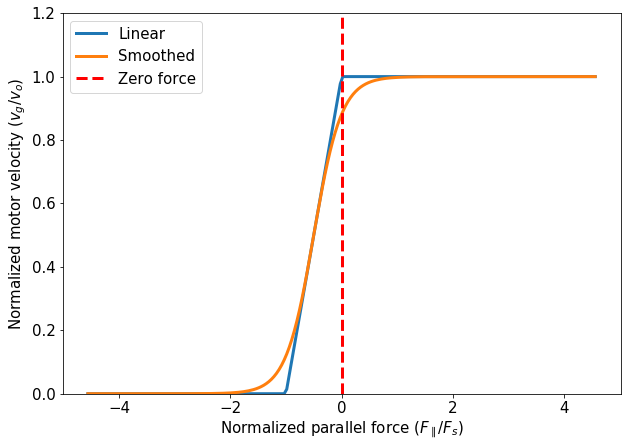

In [10]:
params = deepcopy(default_params_gen)
params[0] = 0
s2 = 0
s1 = np.linspace(-1, 1, 200).tolist()
vel = [vel_force(s, s2, params) for s in s1]
force = np.array([para_force21(s, s2, params) for s in s1])
fig, ax = plt.subplots(figsize=(10,7))
lin_vel = np.piecewise(force, 
                         [force <-1., (force >= -1) & (force < 0), force >= 0], 
                         [0, lambda force: params[11]*(1.+force/params[9]), 1])
ax.plot(force, lin_vel, label="Linear")
ax.plot(force, vel, label="Smoothed")
ax.axvline(x=0, color='r', linestyle='--', label="Zero force")
ax.set_xlabel("Normalized parallel force ($F_{\parallel}/F_s$)")
ax.set_ylabel("Normalized motor velocity ($v_g/v_o$)")
ax.set_ylim(0, 1.2)
ax.legend()
plt.show()

# Spring constant compare

In [11]:
fs = 2.0
ks = .3
ho = 52.
sep = 25.

In [12]:
def get_zrl_parallel_spring_const(ks, fs, ho, sep):
    a = sep*sep
    b = (ks*ks*(ho*ho - sep*sep)) + (fs*fs)
    c = -ks*ks*fs*fs
    
    ks_new = np.sqrt((-1.*b + np.sqrt((b*b)-(4.*a*c)))/(2.*a)) 
    return ks_new

In [13]:
def get_zrl_spring_const(ks, fs, ho, sep):
    return ks*fs/(fs+(ho*ks))

In [14]:
def get_nzrl_parallel_force(x, ks, ho, sep):
    return -1.*ks*x*(1.-(ho/np.sqrt(x*x + sep*sep)))

In [15]:
def get_nzrl_force(h, ks, ho):
    return -1.*ks*(h-ho)

0.03409090909090909


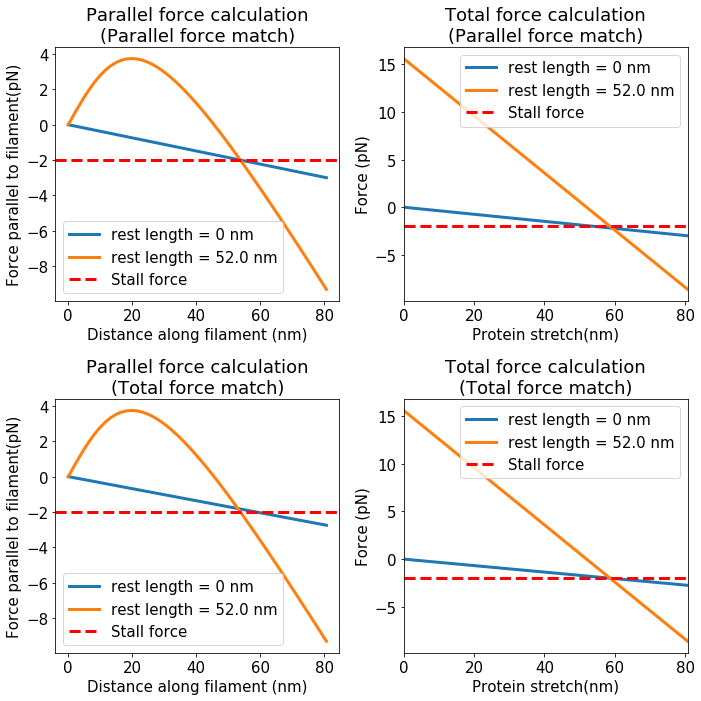

In [24]:
#print(ks)
ks_new1 = 0.03715512882326001
ks_new2 = get_zrl_spring_const(ks, fs, ho, sep)
#print("Matching distance along filament for parallel:", fs/ks_new1)
#print("Matching distance for parallel:", np.sqrt((fs/ks_new1)**2+sep**2))
#print(get_zrl_parallel_force(fs/ks_new1, ks, ho, sep))

x = np.linspace(0,1.5*fs/ks_new1, 50)

fig, axarr = plt.subplots(2,2,figsize=(10,10))
axarr[0,0].plot(x, -ks_new1*x, label='rest length = 0 nm')
axarr[0,0].plot(x, get_nzrl_parallel_force(x,ks,ho,sep), label="rest length = {} nm".format(ho))
axarr[0,0].axhline(y=-fs, color='r', linestyle='--', label="Stall force")
axarr[0,0].set_xlabel('Distance along filament (nm)')
axarr[0,0].set_ylabel('Force parallel to filament(pN)')
axarr[0,0].set_title('Parallel force calculation\n(Parallel force match)')
axarr[0,0].legend()

axarr[0,1].plot(x, -ks_new1*x, label='rest length = 0 nm')
axarr[0,1].plot(x, get_nzrl_force(x,ks,ho), label="rest length = {} nm".format(ho))
axarr[0,1].axhline(y=-fs, color='r', linestyle='--', label="Stall force")
axarr[0,1].set_xlabel('Protein stretch(nm)')
axarr[0,1].set_ylabel('Force (pN)')
axarr[0,1].set_title('Total force calculation\n(Parallel force match)')
axarr[0,1].set_xlim(0,1.5*fs/ks_new1)
axarr[0,1].legend()
#axarr[0].set_ylim(-5, 0)


print(ks_new2)
#print("Matching distance along filament for parallel:", np.sqrt((fs/ks_new1)**2 - sep**2))
#print("Matching distance for general:", fs/ks_new2)
#print(get_zrl_parallel_force(fs/ks_new1, ks, ho, sep))
axarr[1,0].plot(x, -ks_new2*x, label='rest length = 0 nm')
axarr[1,0].plot(x, get_nzrl_parallel_force(x,ks,ho,sep), label="rest length = {} nm".format(ho))
axarr[1,0].axhline(y=-fs, color='r', linestyle='--', label="Stall force")
axarr[1,0].set_xlabel('Distance along filament (nm)')
axarr[1,0].set_ylabel('Force parallel to filament(pN)')
axarr[1,0].set_title('Parallel force calculation\n(Total force match)')
axarr[1,0].legend()
axarr[1,1].plot(x, -ks_new2*x, label='rest length = 0 nm')
axarr[1,1].plot(x, get_nzrl_force(x,ks,ho), label="rest length = {} nm".format(ho))
axarr[1,1].axhline(y=-fs, color='r', linestyle='--', label="Stall force")
axarr[1,1].set_xlabel('Protein stretch(nm)')
axarr[1,1].set_ylabel('Force (pN)')
axarr[1,1].set_title('Total force calculation\n(Total force match)')
axarr[1,1].set_xlim(0,1.5*fs/ks_new1)
axarr[1,1].legend()
#axarr[1].set_ylim(-5, 0)
plt.tight_layout()

In [ ]:
#print(ks)
ks_new1 = 0.03715512882326001
ks_new2 = get_zrl_spring_const(ks, fs, ho, sep)
#print("Matching distance along filament for parallel:", fs/ks_new1)
#print("Matching distance for parallel:", np.sqrt((fs/ks_new1)**2+sep**2))
#print(get_zrl_parallel_force(fs/ks_new1, ks, ho, sep))

x = np.linspace(0,1.5*fs/ks_new1, 50)

fig, axarr = plt.subplots(1,2,figsize=(10,5))
#axarr[0,0].plot(x, -ks_new1*x)
#axarr[0,0].plot(x, get_nzrl_parallel_force(x,ks,ho,sep))
#axarr[0,0].axhline(y=-fs, color='r', linestyle='--', label="Stall force")
#axarr[0,0].set_xlabel('Distance along filament (nm)')
#axarr[0,0].set_ylabel('Force parallel to filament(pN)')
#axarr[0,0].set_title('Parallel force calculation')
#axarr[0,1].plot(x, -ks_new1*x)
#axarr[0,1].plot(x, get_nzrl_force(x,ks,ho,sep))
#axarr[0,1].axhline(y=-fs, color='r', linestyle='--', label="Parallel force")
#axarr[0,1].set_xlabel('Protein stretch(nm)')
#axarr[0,1].set_ylabel('Force (pN)')
#axarr[0,1].set_title('Total force calculation')
#axarr[0,1].set_xlim(0,1.5*fs/ks_new1)
#axarr[0].set_ylim(-5, 0)


print(ks_new2)
#print("Matching distance along filament for parallel:", np.sqrt((fs/ks_new1)**2 - sep**2))
#print("Matching distance for general:", fs/ks_new2)
#print(get_zrl_parallel_force(fs/ks_new1, ks, ho, sep))
axarr[1,0].plot(x, -ks_new2*x)
axarr[1,0].plot(x, get_nzrl_parallel_force(x,ks,ho,sep))
axarr[1,0].axhline(y=-fs, color='r', linestyle='--', label="Parallel force")
axarr[1,0].set_xlabel('Distance along filament (nm)')
axarr[1,0].set_ylabel('Force parallel to filament(pN)')
axarr[1,0].set_title('Parallel force calculation')
axarr[1,1].plot(x, -ks_new2*x)
axarr[1,1].plot(x, get_nzrl_force(x,ks,ho,sep))
axarr[1,1].axhline(y=-fs, color='r', linestyle='--', label="Parallel force")
axarr[1,1].set_xlabel('Protein stretch(nm)')
axarr[1,1].set_ylabel('Force (pN)')
axarr[1,1].set_title('Total force calculation')
axarr[1,1].set_xlim(0,1.5*fs/ks_new1)
#axarr[1].set_ylim(-5, 0)
plt.tight_layout()

# Solutions to steady state

In [11]:
phi = Function('phi')

In [12]:
s1_arr = np.asarray([3,5,8])
s2_arr = np.asarray([4,12,15])
print(s1_arr)
print(s2_arr)

[3 5 8]
[ 4 12 15]


In [13]:
Y,X = np.meshgrid(s2_arr, s1_arr)

In [14]:
print(X)
print(Y)
c = np.sqrt(np.power(X,2)+np.power(Y,2))


[[3 3 3]
 [5 5 5]
 [8 8 8]]
[[ 4 12 15]
 [ 4 12 15]
 [ 4 12 15]]


In [15]:
import time
a = np.linspace(0,1,1000)
b = np.linspace(1,2,1000)
X, Y = np.meshgrid(a,b)
t0 = time.time()
c = np.sqrt(np.power(X,2)+np.power(Y,2))
t1 = time.time()
print("Total time: ", t1-t0)

('Total time: ', 0.057057857513427734)


In [16]:
t0 = time.time()
c = np.exp(np.power(np.sqrt(np.power(X,2)+np.power(Y,2))-.1,2))
t1 = time.time()
print("Total time: ", t1-t0)

('Total time: ', 0.06903910636901855)


In [17]:
print(c)
d = np.asarray([1,2,3])
e = np.outer(d,c)
print(e.shape)

[[  2.24790799   2.24791001   2.2479161  ...,   5.60377387   5.61419277
    5.62464192]
 [  2.25196418   2.25196621   2.2519723  ...,   5.61421368   5.6246524
    5.63512141]
 [  2.25603221   2.25603425   2.25604035 ...,   5.62468382   5.6351424
    5.64563134]
 ..., 
 [ 36.68604364  36.68607856  36.68618332 ...,  94.75736446  94.93847648
   95.12011845]
 [ 36.82574519  36.82578025  36.82588541 ...,  95.12020949  95.30201844
   95.48435939]
 [ 36.96605281  36.966088    36.96619357 ...,  95.48463357  95.6671425
   95.85018547]]
(3, 1000000)


In [18]:
s1 = np.arange(5)
s2 = np.arange(5,9)
print(s1, s2)
u1=np.asarray([1,0,0])
u2=np.asarray([0,1,0])
S2, S1 = np.meshgrid(s2,s1)

(array([0, 1, 2, 3, 4]), array([5, 6, 7, 8]))


In [19]:
hvec = S2[:,:,None]*u2[None,None,:]-S1[:,:,None]*u1[None,None,:]
print(hvec)

[[[ 0  5  0]
  [ 0  6  0]
  [ 0  7  0]
  [ 0  8  0]]

 [[-1  5  0]
  [-1  6  0]
  [-1  7  0]
  [-1  8  0]]

 [[-2  5  0]
  [-2  6  0]
  [-2  7  0]
  [-2  8  0]]

 [[-3  5  0]
  [-3  6  0]
  [-3  7  0]
  [-3  8  0]]

 [[-4  5  0]
  [-4  6  0]
  [-4  7  0]
  [-4  8  0]]]


In [20]:
A = np.linalg.norm(hvec, axis=2)
print(A)

[[ 5.          6.          7.          8.        ]
 [ 5.09901951  6.08276253  7.07106781  8.06225775]
 [ 5.38516481  6.32455532  7.28010989  8.24621125]
 [ 5.83095189  6.70820393  7.61577311  8.54400375]
 [ 6.40312424  7.21110255  8.06225775  8.94427191]]


In [21]:
B = np.ones((5,4,3))
B[:,:,1]*=2
B[:,:,2]*=3
print(B)

[[[ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]]

 [[ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]]

 [[ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]]

 [[ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]]

 [[ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]
  [ 1.  2.  3.]]]


In [22]:
C = A[:,:,None]*B[:,:,:]

In [23]:
print(C)

[[[  5.          10.          15.        ]
  [  6.          12.          18.        ]
  [  7.          14.          21.        ]
  [  8.          16.          24.        ]]

 [[  5.09901951  10.19803903  15.29705854]
  [  6.08276253  12.16552506  18.24828759]
  [  7.07106781  14.14213562  21.21320344]
  [  8.06225775  16.1245155   24.18677324]]

 [[  5.38516481  10.77032961  16.15549442]
  [  6.32455532  12.64911064  18.97366596]
  [  7.28010989  14.56021978  21.84032967]
  [  8.24621125  16.4924225   24.73863375]]

 [[  5.83095189  11.66190379  17.49285568]
  [  6.70820393  13.41640786  20.1246118 ]
  [  7.61577311  15.23154621  22.84731932]
  [  8.54400375  17.08800749  25.63201124]]

 [[  6.40312424  12.80624847  19.20937271]
  [  7.21110255  14.4222051   21.63330765]
  [  8.06225775  16.1245155   24.18677324]
  [  8.94427191  17.88854382  26.83281573]]]


In [24]:
print(C.sum(axis=(0,1)))

[ 138.870838    277.74167599  416.61251399]


In [25]:
v = np.asarray([[1,0,0],[0,1,0],[0,0,1],[1,0,0]])
print(v)

[[1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]]


In [26]:
D = np.cross(v,C)

In [27]:
print(D)

[[[  0.         -15.          10.        ]
  [ 18.           0.          -6.        ]
  [-14.           7.           0.        ]
  [  0.         -24.          16.        ]]

 [[  0.         -15.29705854  10.19803903]
  [ 18.24828759   0.          -6.08276253]
  [-14.14213562   7.07106781   0.        ]
  [  0.         -24.18677324  16.1245155 ]]

 [[  0.         -16.15549442  10.77032961]
  [ 18.97366596   0.          -6.32455532]
  [-14.56021978   7.28010989   0.        ]
  [  0.         -24.73863375  16.4924225 ]]

 [[  0.         -17.49285568  11.66190379]
  [ 20.1246118    0.          -6.70820393]
  [-15.23154621   7.61577311   0.        ]
  [  0.         -25.63201124  17.08800749]]

 [[  0.         -19.20937271  12.80624847]
  [ 21.63330765   0.          -7.21110255]
  [-16.1245155    8.06225775   0.        ]
  [  0.         -26.83281573  17.88854382]]]


In [28]:
u = np.asarray([1,2,3])
uu = np.outer(u,u)
print(uu)

[[1 2 3]
 [2 4 6]
 [3 6 9]]


In [29]:
np.power(uu,2)

array([[ 1,  4,  9],
       [ 4, 16, 36],
       [ 9, 36, 81]])

In [30]:
Iish = np.eye(3)
print(Iish)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


# Source testing